<a href="https://colab.research.google.com/github/sungbaejo/serverless_region/blob/master/serverless_region_category.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Serverless Region별 성능 비교에 따른 최적 Region 선택 학습 모델
---


*   Serverless 환경 : Google Firebase (GCP)
*   Checkpoint 서비스 : https://www.uptrends.com/ (Monitor log excel export)
*   Checkpoint 위치 : France(Paris), Germany(Berlin,Frankfurt), Italy(Milan), Netherlands(Amsterdam), United Kingdom(London), Canada(Montreal), United States(Dallas, New York, San Diego)
*   Log 수집 기간 : 2019/11/11~2020/03/09 (리전별 2분 간격, Checkpoint는 Random, 총 524174건의 로그) 






In [1]:
# Requires the latest pip
!pip install --upgrade pip

# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

!pip install sklearn

#!pip install --upgrade pandas


# For a specific version:
#!pip install tensorflow==2.1

# For the latest nightly build:
#!pip install tf-nightly

     |████████████████████████████████| 1.4MB 2.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
Name: tensorflow
Version: 1.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: google-pasta, tensorboard, termcolor, numpy, astor, gast, wrapt, grpcio, opt-einsum, wheel, keras-preprocessing, keras-applications, tensorflow-estimator, absl-py, protobuf, six
Required-by: stable-baselines, magenta, fancyimpute
     |████████████████████████████████| 421.8 MB 22 kB/s 
     |████████████████████████████████| 448 kB 77.6 MB/s 
     |████████████████████████████████| 3.8 MB 53.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estima

In [2]:
# Use seaborn for pairplot
!pip install -q seaborn

!pip install pandas
#!pip install --upgrade pandas

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = '{:20,.2f}'.format

import sys
print(sys.version_info)

sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)


In [5]:
import tensorflow as tf

from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

print(tf.__version__)

2.1.0


In [0]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1YQs2XR3n-FGjn-bDaqXqKWjXeFtFd8Oi'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile ('log.csv') #directory : content
# print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [8]:
raw_dataset = pd.read_csv('log.csv', thousands=',')

df = raw_dataset.copy()
df.tail()

ErrorLevel              Timestamp  ... DownloadTime  DownloadSize
524169   No error  11/11/2019 7:53:20 PM  ...            0           558
524170   No error  11/11/2019 7:52:31 PM  ...            0           558
524171   No error  11/11/2019 7:51:55 PM  ...            0           558
524172   No error  11/11/2019 7:51:22 PM  ...            0           558
524173   No error  11/11/2019 7:50:58 PM  ...            0           558

[5 rows x 12 columns]

In [9]:
df.isna().sum()

ErrorLevel         0
Timestamp          0
Region             0
RTT                0
StatusCode         0
Description        0
Checkpoint         0
IP                43
ResolveTime        0
ConnectionTime     0
DownloadTime       0
DownloadSize       0
dtype: int64

In [10]:
print(len(df))
print(df.ErrorLevel.unique())

524174
['No error' 'Confirmed error' 'Unconfirmed error']


In [11]:
df.drop(df[df.ErrorLevel != "No error"].index, inplace=True)
print(len(df))
print(df.ErrorLevel.unique())

522304
['No error']


In [12]:
print(df.StatusCode.unique())
print(df.Description.unique())
print(df.ResolveTime.unique())
print(df.ConnectionTime.unique())
print(df.DownloadTime.unique())
print(df.DownloadSize.unique())

[0]
['OK']
[0]
[0]
[0]
[558 554 556]


In [13]:
#df.drop(columns=['ErrorLevel', 'StatusCode', 'Description', 'IP', 'ResolveTime', 'ConnectionTime', 'DownloadTime', 'DownloadSize'], inplace=True)
df = df[['Timestamp','Region','RTT','Checkpoint']]
print(len(df))
df.tail()

522304


Timestamp           Region   RTT Checkpoint
524169  11/11/2019 7:53:20 PM     europe-west2   156      Milan
524170  11/11/2019 7:52:31 PM  asia-northeast1  2939      Milan
524171  11/11/2019 7:51:55 PM  asia-northeast1   276   New York
524172  11/11/2019 7:51:22 PM     europe-west2  1161     Dallas
524173  11/11/2019 7:50:58 PM     europe-west2   228  Frankfurt

In [14]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format = '%m/%d/%Y %I:%M:%S %p')
df['Timestamp'].tail()

524169   2019-11-11 19:53:20
524170   2019-11-11 19:52:31
524171   2019-11-11 19:51:55
524172   2019-11-11 19:51:22
524173   2019-11-11 19:50:58
Name: Timestamp, dtype: datetime64[ns]

In [15]:
df.sort_values(by=['Timestamp'], inplace=True)
df['Timestamp'].tail()

4   2020-03-09 13:41:12
3   2020-03-09 13:41:22
2   2020-03-09 13:41:39
1   2020-03-09 13:41:47
0   2020-03-09 13:42:10
Name: Timestamp, dtype: datetime64[ns]

In [16]:
df.reset_index(drop=True, inplace=True)
df

Timestamp           Region   RTT Checkpoint
0      2019-11-11 19:50:58     europe-west2   228  Frankfurt
1      2019-11-11 19:51:22     europe-west2  1161     Dallas
2      2019-11-11 19:51:55  asia-northeast1   276   New York
3      2019-11-11 19:52:31  asia-northeast1  2939      Milan
4      2019-11-11 19:53:20     europe-west2   156      Milan
...                    ...              ...   ...        ...
522299 2020-03-09 13:41:12         us-east1   152     Dallas
522300 2020-03-09 13:41:22      us-central1   243     Berlin
522301 2020-03-09 13:41:39  asia-northeast1   268   New York
522302 2020-03-09 13:41:47       asia-east2   294  San Diego
522303 2020-03-09 13:42:10     europe-west2    68     London

[522304 rows x 4 columns]

In [77]:
grouper = df.groupby([pd.Grouper(key='Timestamp', freq='1D'), 'Checkpoint', 'Region'])
mean_df = grouper['RTT'].mean().unstack() #필요시 .fillna(0) 추가
#mean_df.columns = mean_df.columns.to_flat_index()
print(len(mean_df))
print(mean_df.isna().sum())
print(mean_df.shape)
print(mean_df.columns)
mean_df.reset_index(inplace=True)
mean_df

1200
Region
asia-east2         0
asia-northeast1    0
europe-west1       0
europe-west2       0
us-central1        0
us-east1           0
dtype: int64
(1200, 6)
Index(['asia-east2', 'asia-northeast1', 'europe-west1', 'europe-west2',
       'us-central1', 'us-east1'],
      dtype='object', name='Region')


Region  Timestamp Checkpoint  ...          us-central1             us-east1
0      2019-11-11  Amsterdam  ...               377.75               762.00
1      2019-11-11     Berlin  ...               673.12               695.77
2      2019-11-11     Dallas  ...               130.15               426.15
3      2019-11-11  Frankfurt  ...               325.00               741.33
4      2019-11-11     London  ...               354.33               581.11
...           ...        ...  ...                  ...                  ...
1195   2020-03-09      Milan  ...               218.93               625.53
1196   2020-03-09   Montreal  ...               233.38               152.93
1197   2020-03-09   New York  ...               198.82               219.21
1198   2020-03-09      Paris  ...               727.42             1,366.32
1199   2020-03-09  San Diego  ...               156.03               491.54

[1200 rows x 8 columns]

In [74]:
mean_df['Min'] = mean_df[['Amsterdam', 'Berlin', 'Dallas', 'Frankfurt', 'London', 'Milan', 'Montreal', 'New York', 'Paris', 'San Diego']].idxmin(axis=1)
mean_df

Checkpoint  Timestamp           Region  ...            San Diego        Min
0          2019-11-11       asia-east2  ...               788.12     London
1          2019-11-11  asia-northeast1  ...               716.33   Montreal
2          2019-11-11     europe-west1  ...               480.10   New York
3          2019-11-11     europe-west2  ...               874.69     London
4          2019-11-11      us-central1  ...               275.13     Dallas
..                ...              ...  ...                  ...        ...
715        2020-03-09  asia-northeast1  ...               304.35  San Diego
716        2020-03-09     europe-west1  ...               321.09  Amsterdam
717        2020-03-09     europe-west2  ...               910.07     London
718        2020-03-09      us-central1  ...               156.03     Dallas
719        2020-03-09         us-east1  ...               491.54   Montreal

[720 rows x 13 columns]

In [0]:
df['Timestamp_day'] = mean_df['Timestamp'].dt.day
df['Timestamp_dayofweek'] = df['Timestamp'].dt.dayofweek
df

Timestamp  ... Timestamp_dayofweek
0      2019-11-11 19:50:58  ...                   0
1      2019-11-11 19:51:22  ...                   0
2      2019-11-11 19:51:55  ...                   0
3      2019-11-11 19:52:31  ...                   0
4      2019-11-11 19:53:20  ...                   0
...                    ...  ...                 ...
522299 2020-03-09 13:41:12  ...                   0
522300 2020-03-09 13:41:22  ...                   0
522301 2020-03-09 13:41:39  ...                   0
522302 2020-03-09 13:41:47  ...                   0
522303 2020-03-09 13:42:10  ...                   0

[522304 rows x 11 columns]

In [0]:
df.describe()

RTT  Timestamp_year  ...  Timestamp_minute  Timestamp_dayofweek
count  522304.000000   522304.000000  ...     522304.000000        522304.000000
mean      590.690556     2019.577330  ...         29.484331             3.007501
std       743.541406        0.493984  ...         17.318085             1.996969
min        31.000000     2019.000000  ...          0.000000             0.000000
25%       168.000000     2019.000000  ...         14.000000             1.000000
50%       275.000000     2020.000000  ...         29.000000             3.000000
75%       770.000000     2020.000000  ...         44.000000             5.000000
max     36316.000000     2020.000000  ...         59.000000             6.000000

[8 rows x 8 columns]

In [0]:
df.dtypes

Timestamp              datetime64[ns]
Region                         object
RTT                             int64
Checkpoint                     object
Timestamp_year                  int64
Timestamp_month                 int64
Timestamp_week                  int64
Timestamp_day                   int64
Timestamp_hour                  int64
Timestamp_minute                int64
Timestamp_dayofweek             int64
dtype: object

In [0]:
df['Timestamp_dayofweek'].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [0]:
grouper = df[['Region',"RTT"]].groupby(['Region']).count()
grouper.rename(columns={"RTT": "CallCount"})

CallCount
Region                    
asia-east2           86838
asia-northeast1      87030
europe-west1         87085
europe-west2         87118
us-central1          87173
us-east1             87060

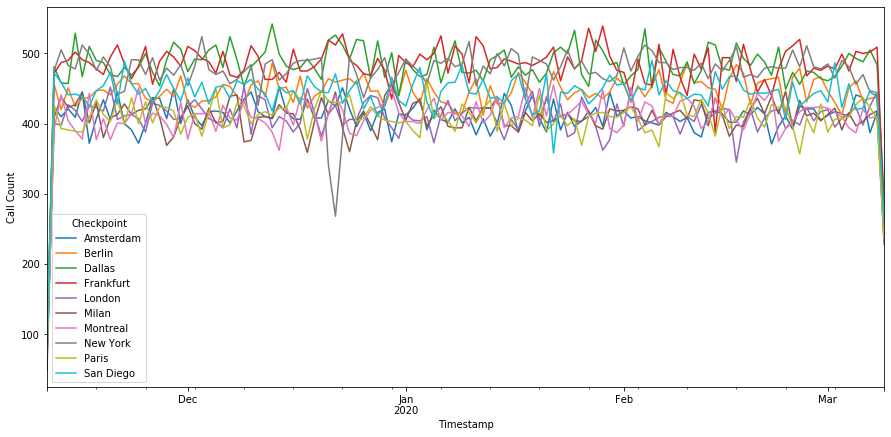

In [0]:
grouper = df.groupby([pd.Grouper(key='Timestamp', freq='1D'), 'Checkpoint'])
mean_result = grouper['RTT'].count().unstack() #필요시 .fillna(0) 추가

fig, ax = plt.subplots(figsize=(15,7))
mean_result.plot(ax=ax)
plt.xlabel("Timestamp")
plt.ylabel("Call Count")
plt.show()

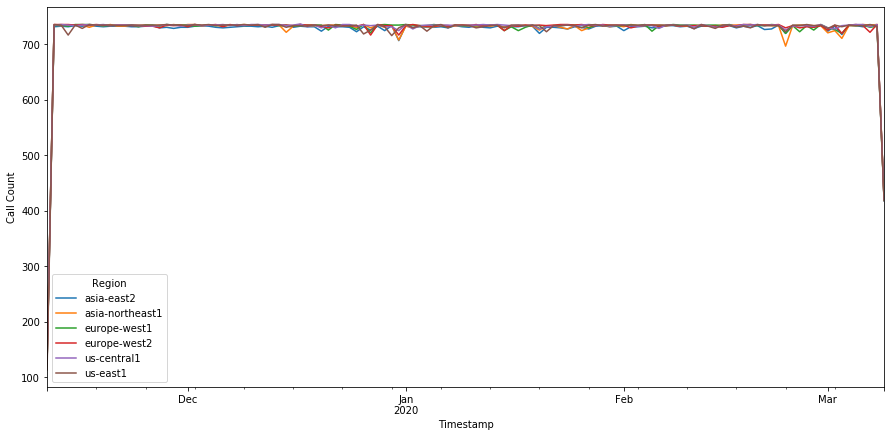

In [0]:
grouper = df.groupby([pd.Grouper(key='Timestamp', freq='1D'), 'Region'])
mean_result = grouper['RTT'].count().unstack() #필요시 .fillna(0) 추가

fig, ax = plt.subplots(figsize=(15,7))
mean_result.plot(ax=ax)
plt.xlabel("Timestamp")
plt.ylabel("Call Count")
plt.show()

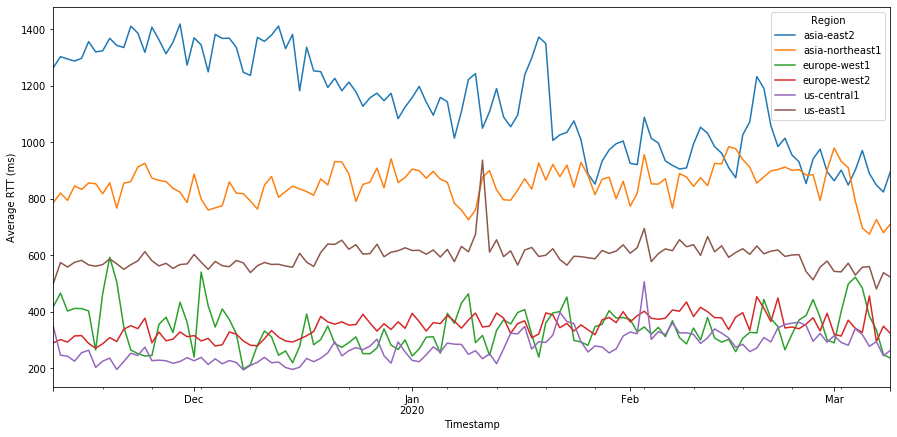

In [0]:
#@title
grouper = df.groupby([pd.Grouper(key='Timestamp', freq='1D'), 'Region'])
mean_result = grouper['RTT'].mean().unstack() #필요시 .fillna(0) 추가

fig, ax = plt.subplots(figsize=(15,7))
mean_result.plot(ax=ax)
plt.xlabel("Timestamp")
plt.ylabel("Average RTT (ms)")
plt.show()

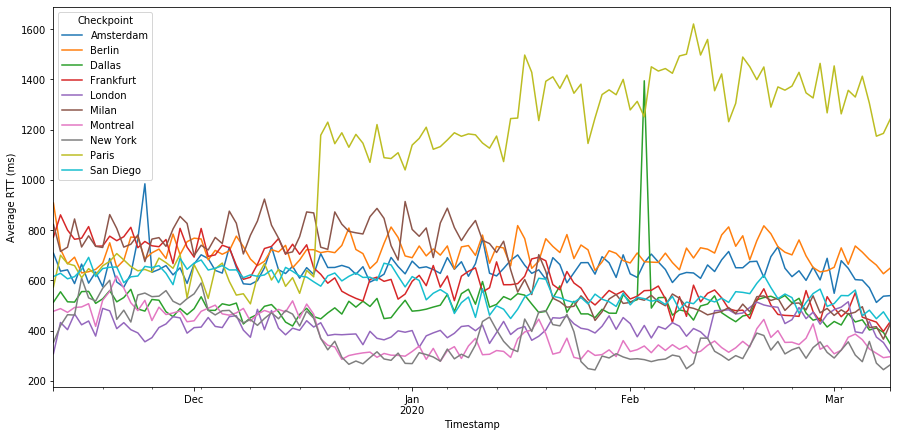

In [0]:
grouper = df.groupby([pd.Grouper(key='Timestamp', freq='1D'), 'Checkpoint'])
mean_result = grouper['RTT'].mean().unstack() #필요시 .fillna(0) 추가

fig, ax = plt.subplots(figsize=(15,7))
mean_result.plot(ax=ax)
plt.xlabel("Timestamp")
plt.ylabel("Average RTT (ms)")
plt.show()

europe-west2


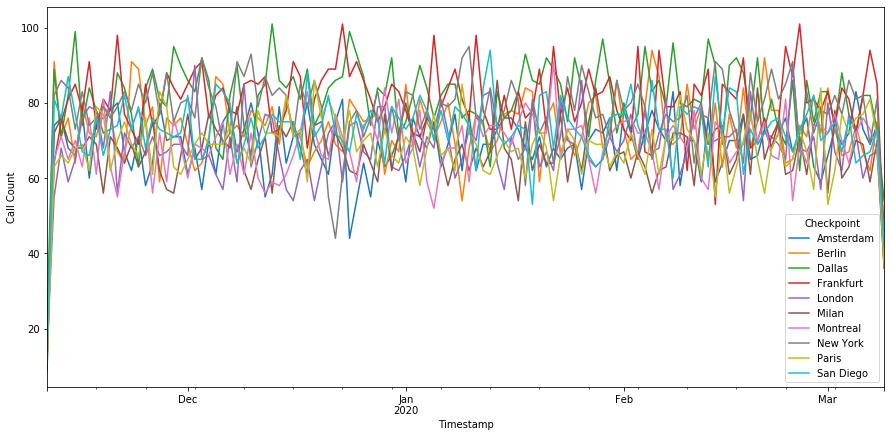

asia-northeast1


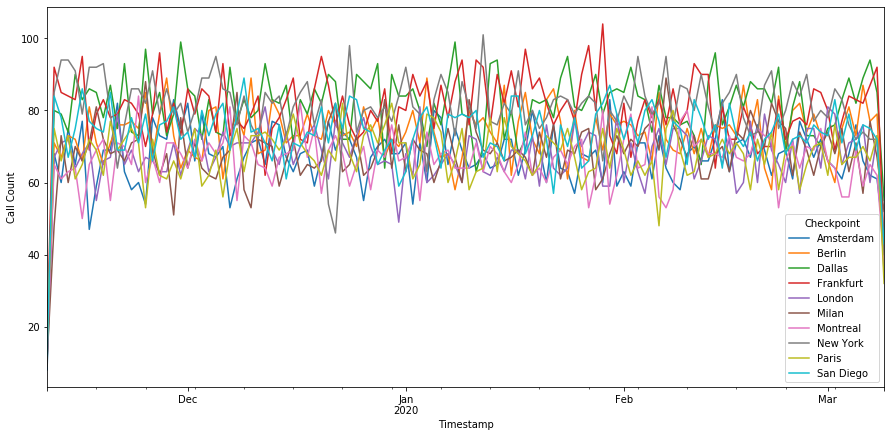

us-central1


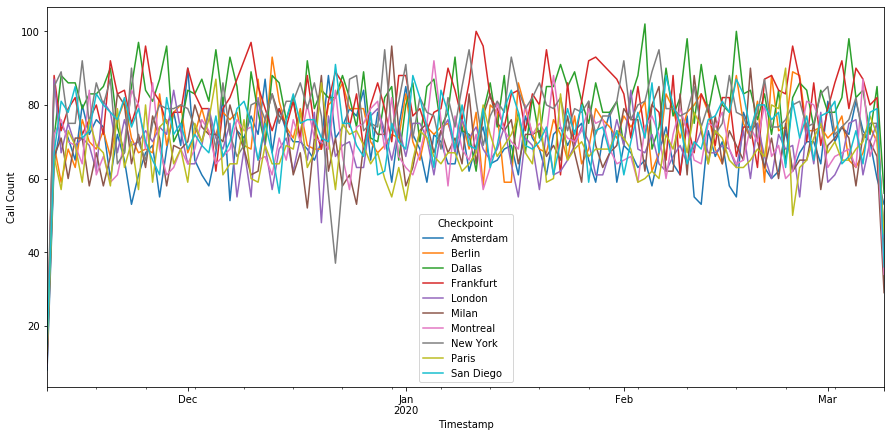

asia-east2


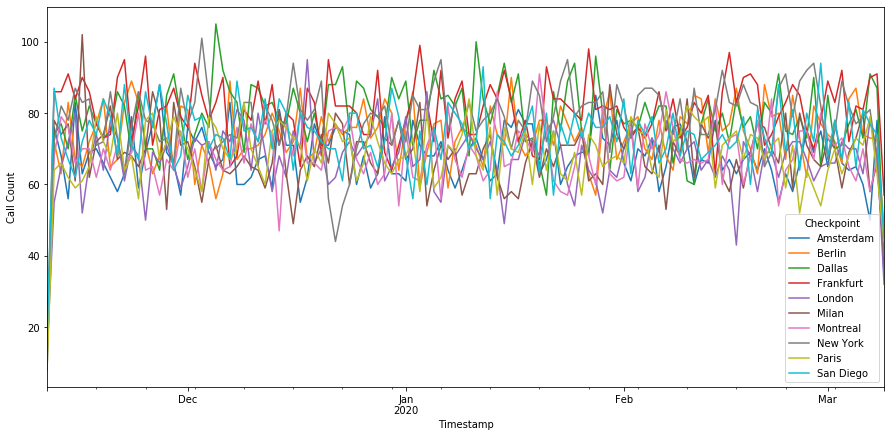

us-east1


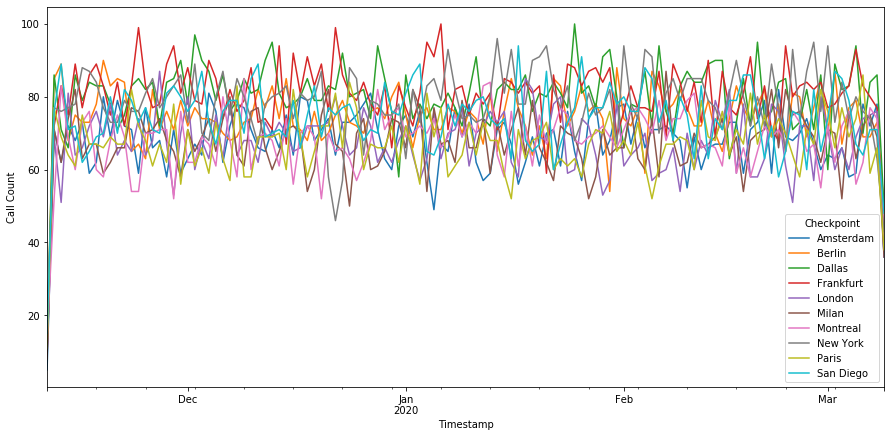

europe-west1


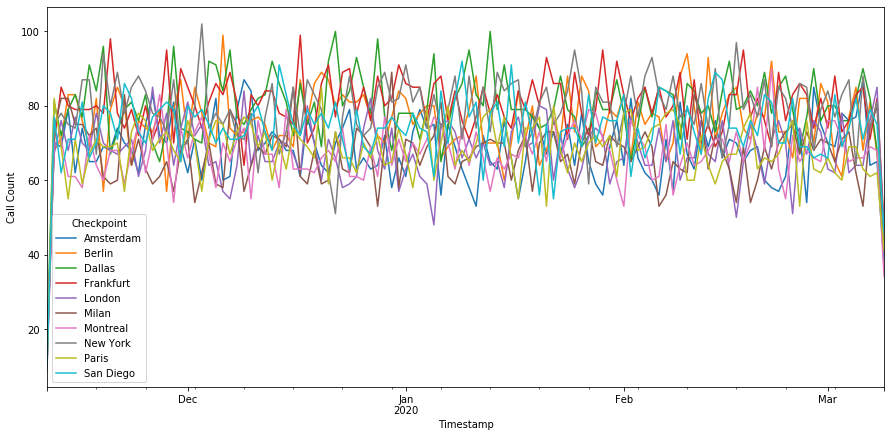

In [0]:
region_series = df['Region'].unique()
for region in region_series:
  print(region)  
  grouper = df.query("Region==@region").groupby([pd.Grouper(key='Timestamp', freq='1D'), 'Checkpoint'])
  mean_result = grouper['RTT'].count().unstack() #필요시 .fillna(0) 추가

  fig, ax = plt.subplots(figsize=(15,7))
  mean_result.plot(ax=ax)
  plt.xlabel("Timestamp")
  plt.ylabel("Call Count")
  plt.show()

europe-west2


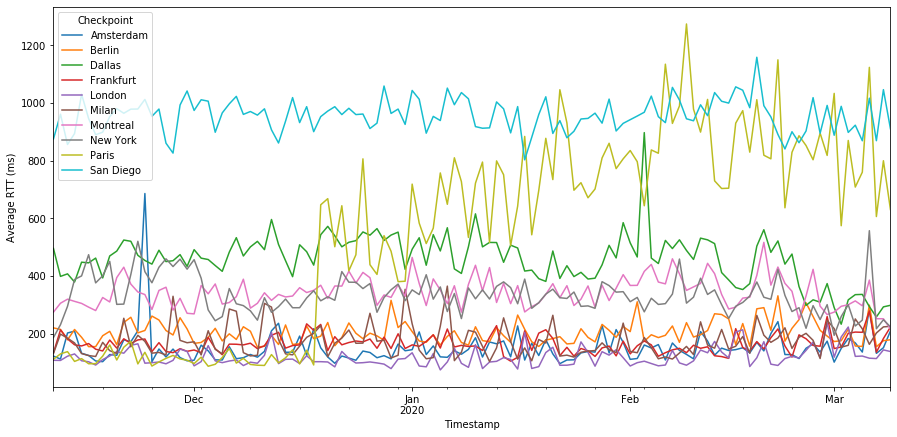

asia-northeast1


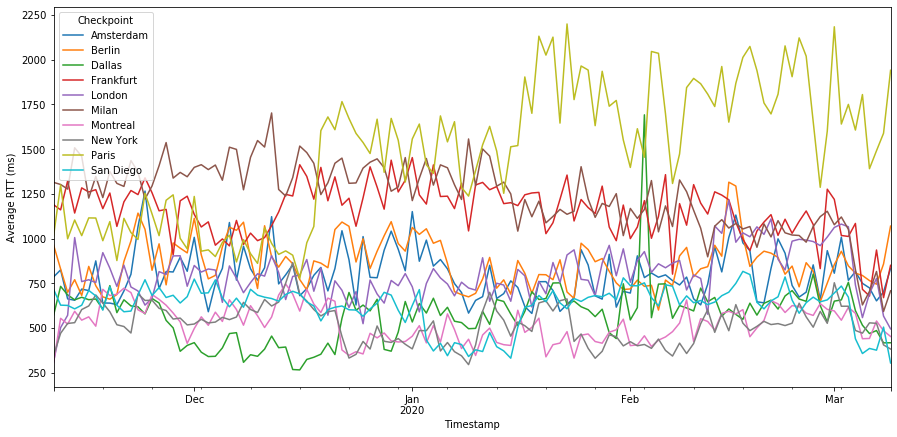

us-central1


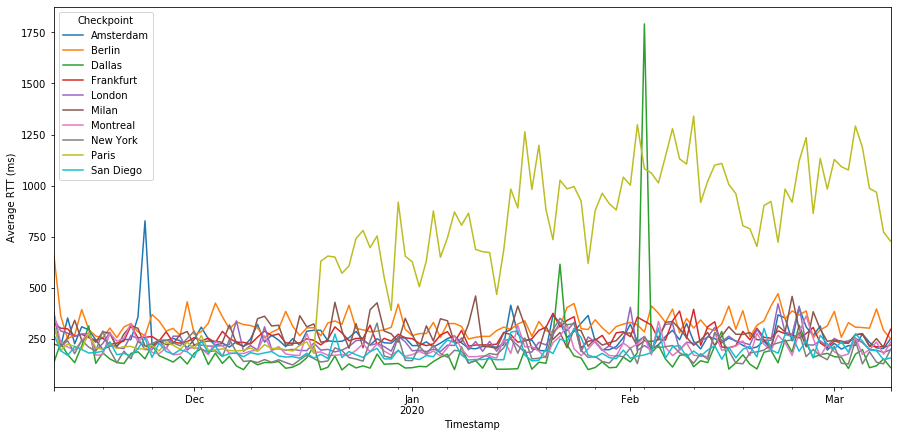

asia-east2


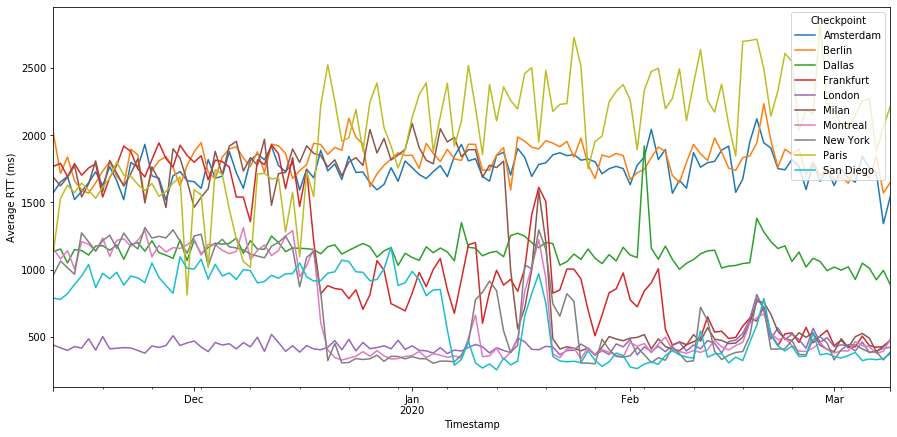

us-east1


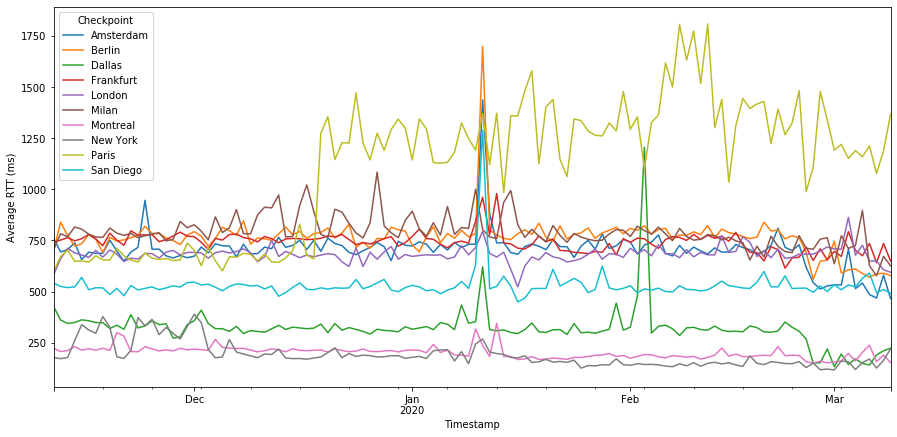

europe-west1


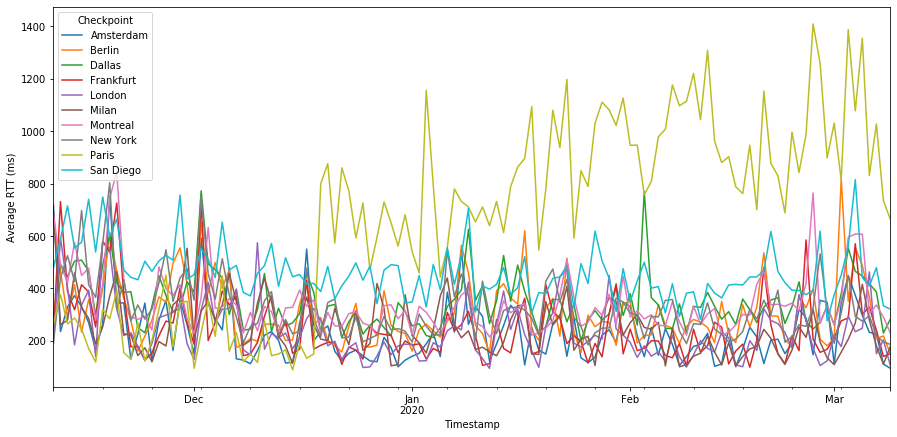

In [0]:
region_series = df['Region'].unique()
for region in region_series:
  print(region)  
  grouper = df.query("Region==@region").groupby([pd.Grouper(key='Timestamp', freq='1D'), 'Checkpoint'])
  mean_result = grouper['RTT'].mean().unstack() #필요시 .fillna(0) 추가

  fig, ax = plt.subplots(figsize=(15,7))
  mean_result.plot(ax=ax)
  plt.xlabel("Timestamp")
  plt.ylabel("Average RTT (ms)")
  plt.show()

Frankfurt


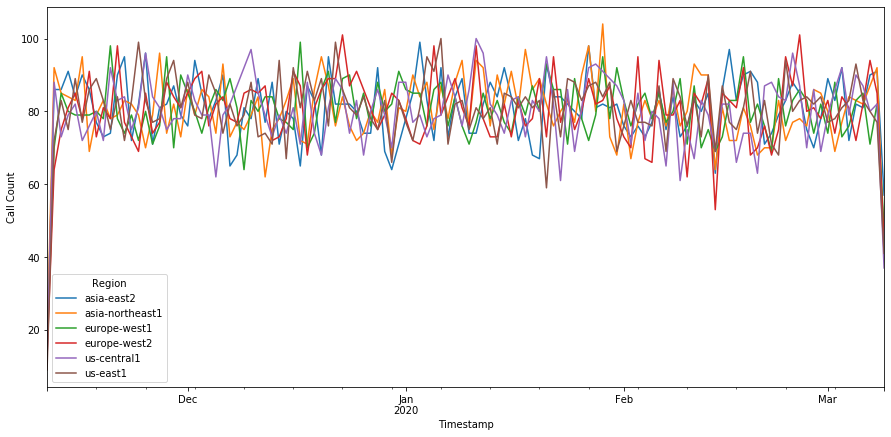

Dallas


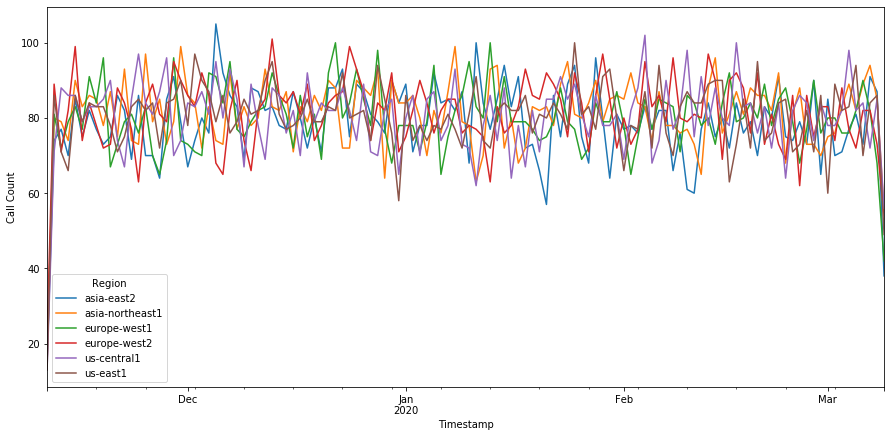

New York


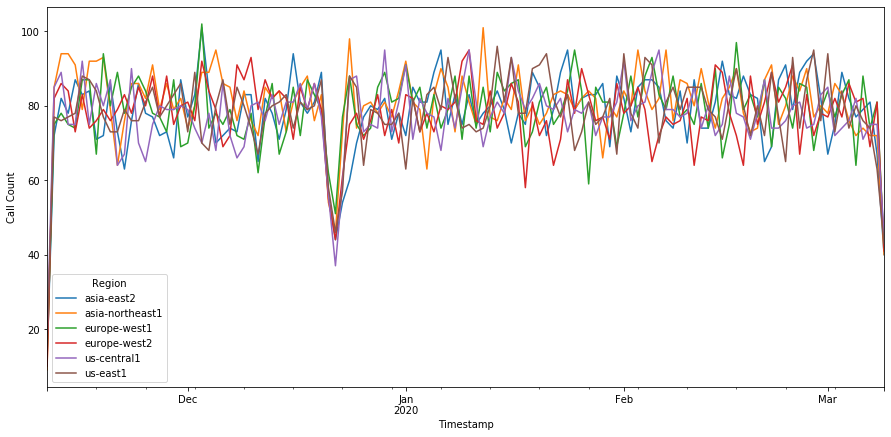

Milan


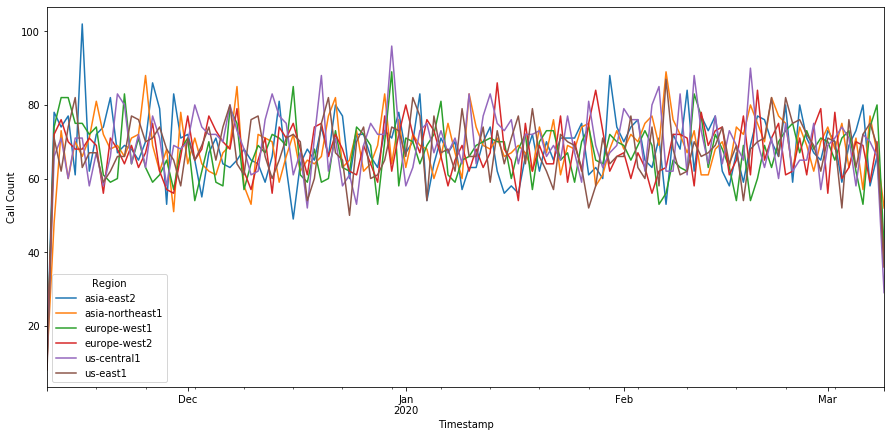

San Diego


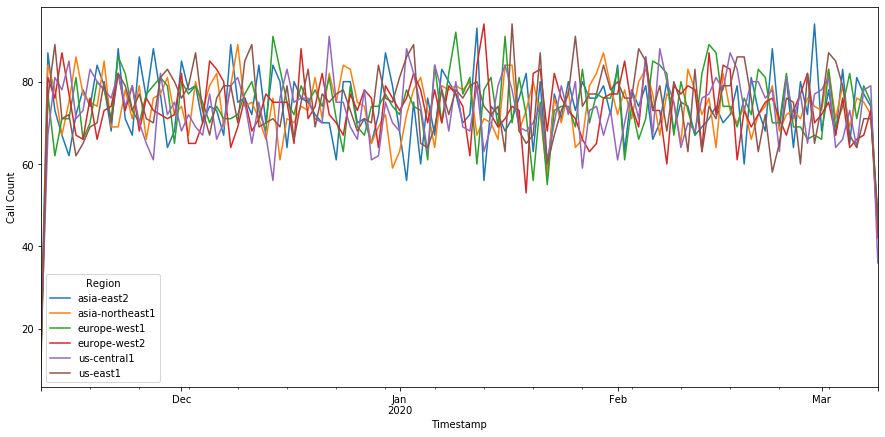

Berlin


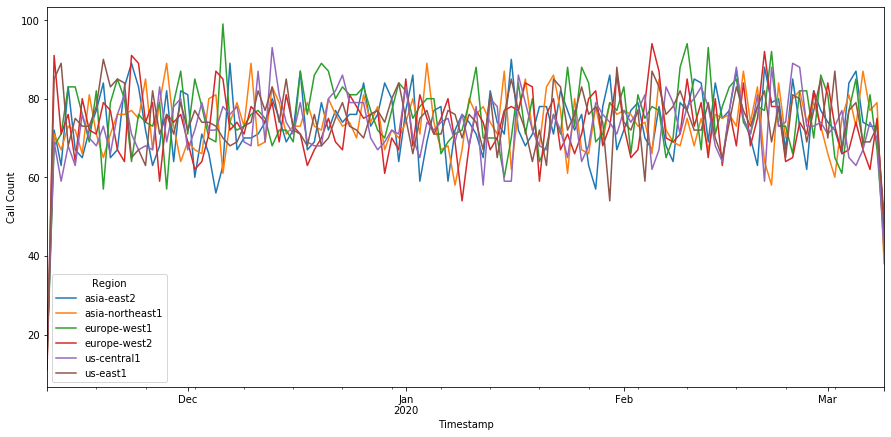

Paris


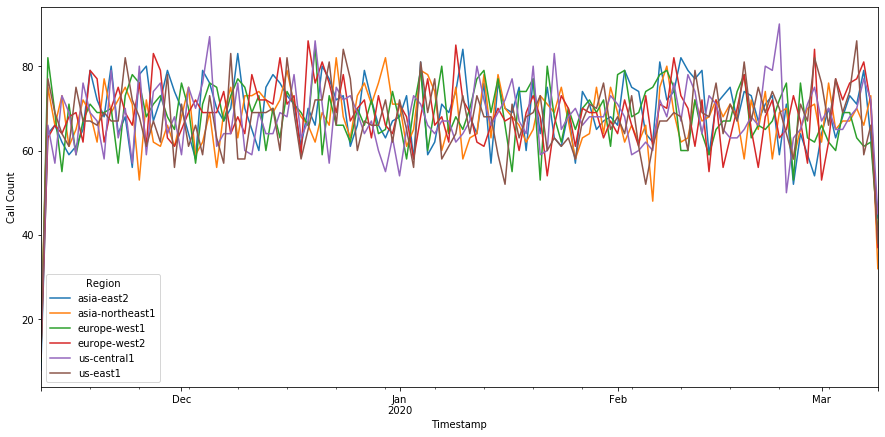

Montreal


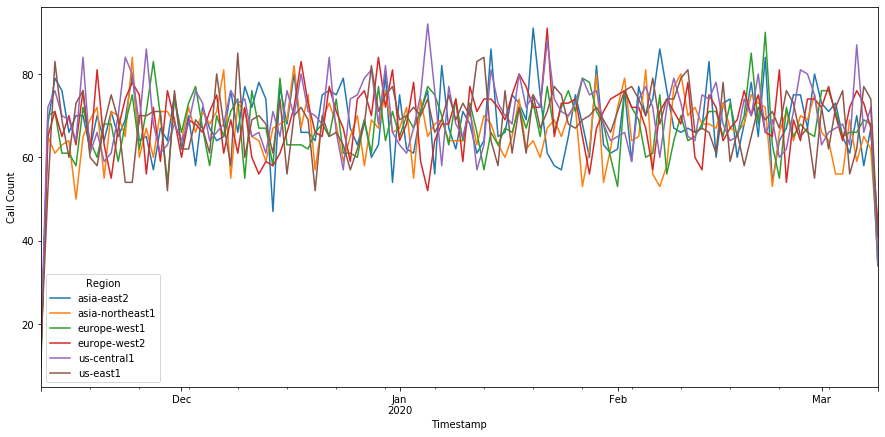

Amsterdam


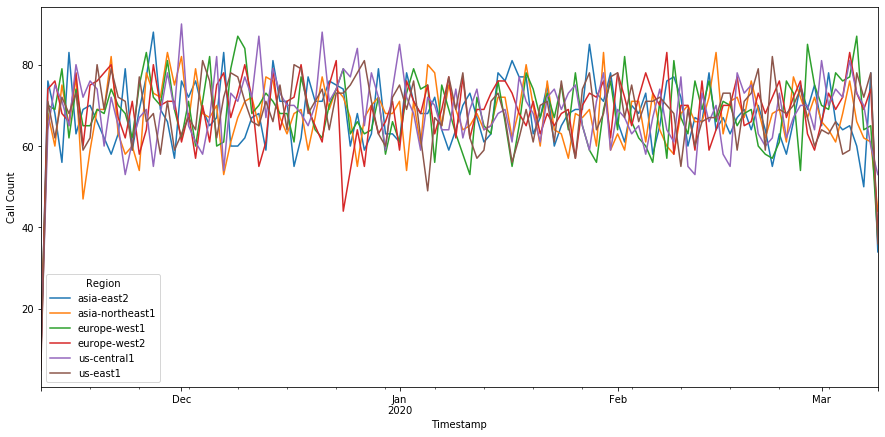

London


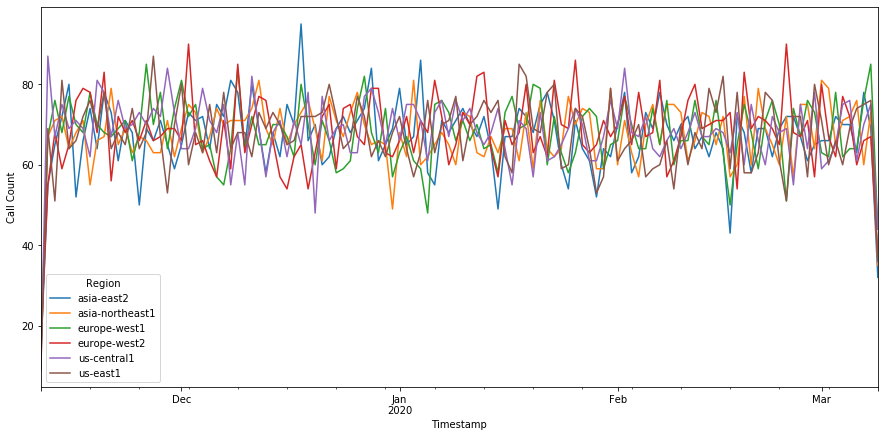

In [0]:
checkpoint_series = df['Checkpoint'].unique()
for checkpoint in checkpoint_series:
  print(checkpoint)  
  grouper = df.query("Checkpoint==@checkpoint").groupby([pd.Grouper(key='Timestamp', freq='1D'), 'Region'])
  mean_result = grouper['RTT'].count().unstack() #필요시 .fillna(0) 추가

  fig, ax = plt.subplots(figsize=(15,7))
  mean_result.plot(ax=ax)
  plt.xlabel("Timestamp")
  plt.ylabel("Call Count")
  plt.show()

Frankfurt


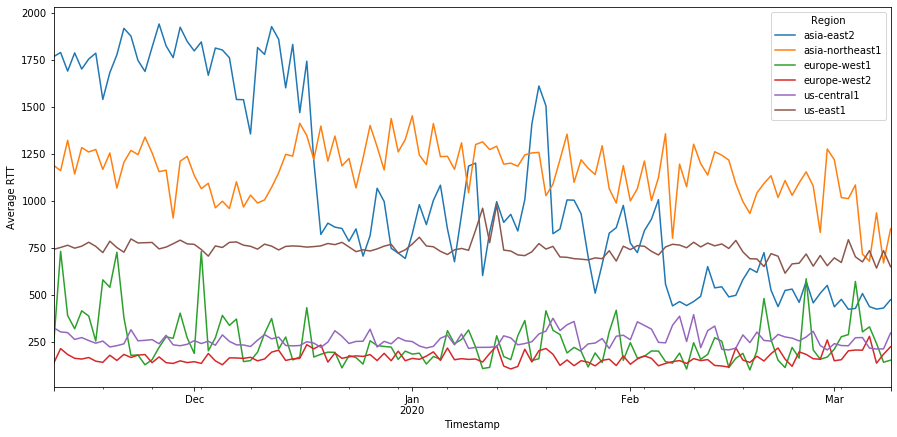

Dallas


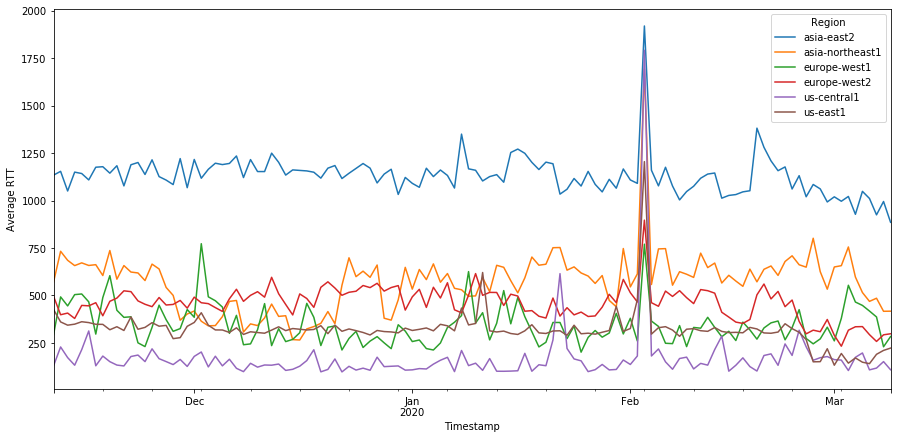

New York


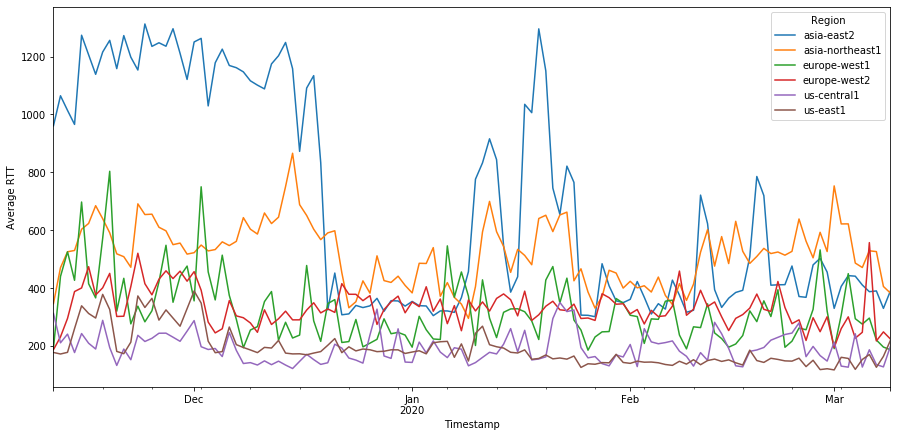

Milan


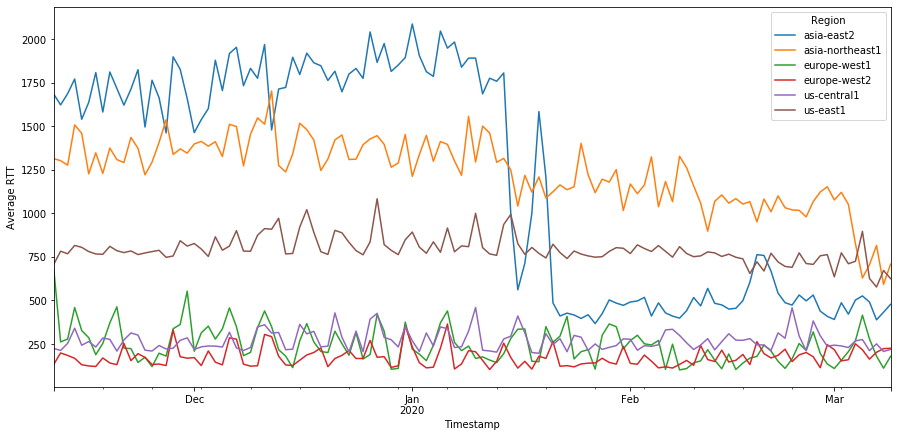

San Diego


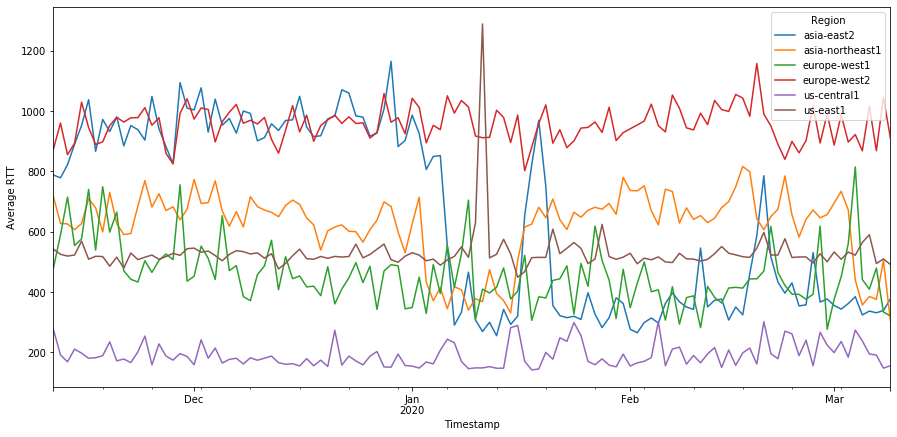

Berlin


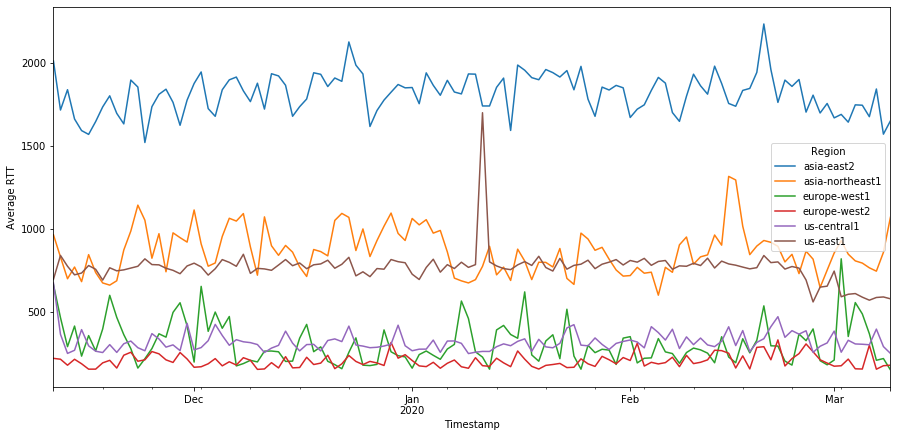

Paris


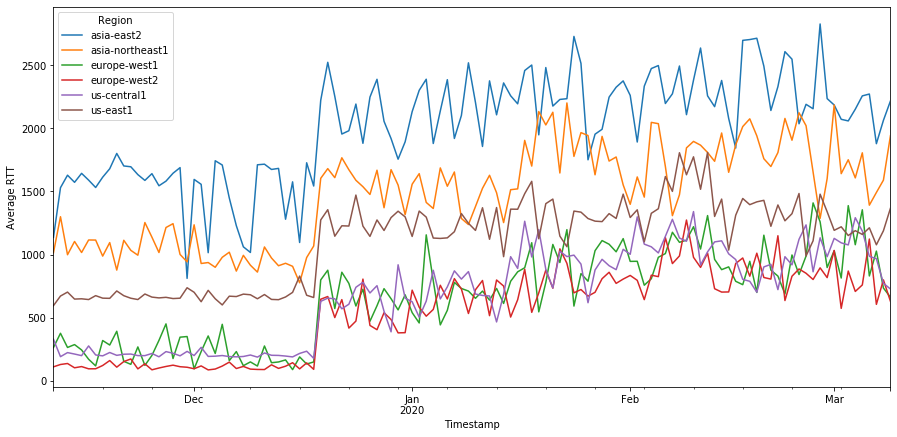

Montreal


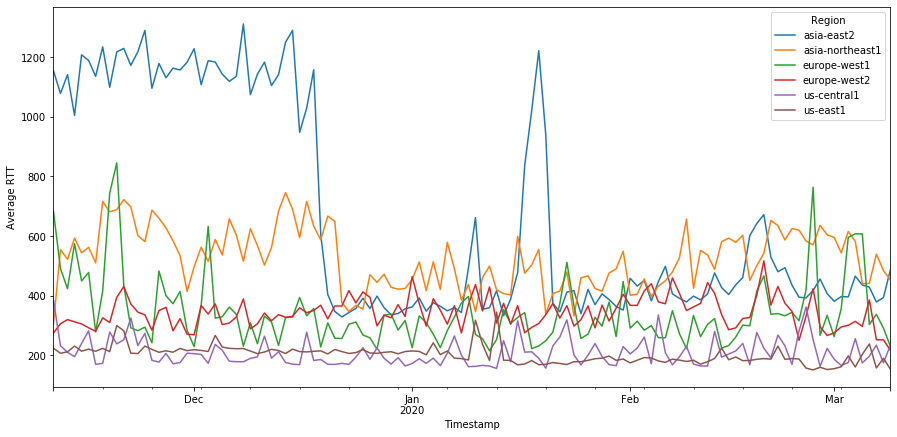

Amsterdam


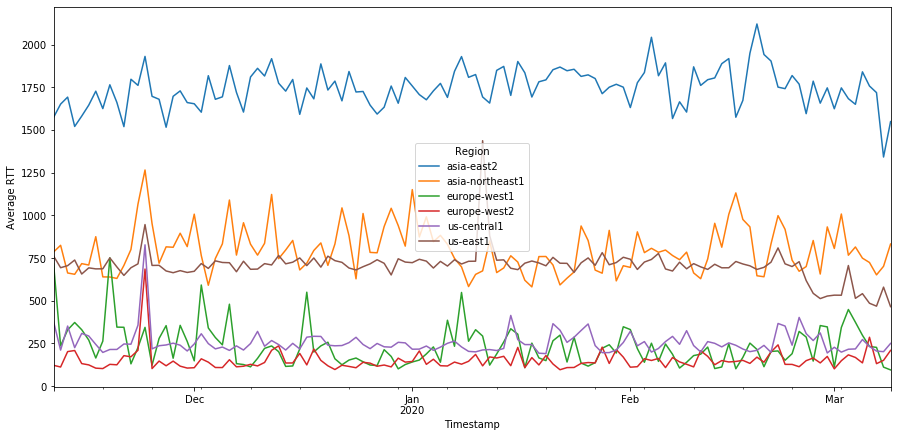

London


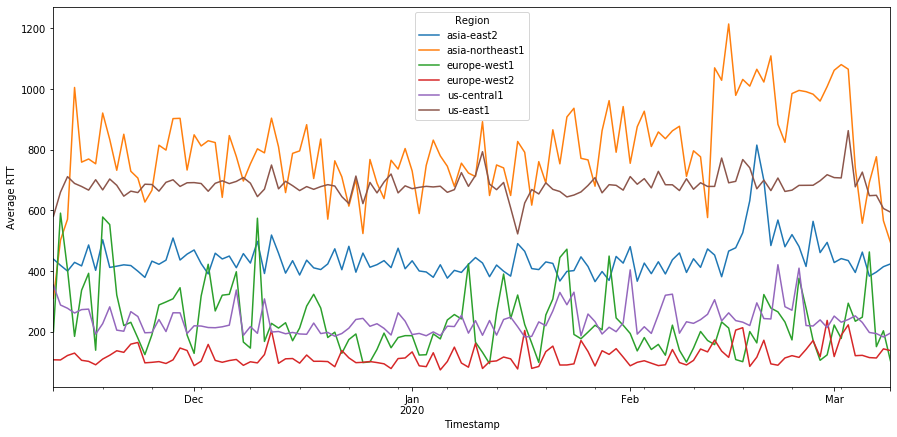

In [0]:
checkpoint_series = df['Checkpoint'].unique()
for checkpoint in checkpoint_series:
  print(checkpoint)  
  grouper = df.query("Checkpoint==@checkpoint").groupby([pd.Grouper(key='Timestamp', freq='1D'), 'Region'])
  mean_result = grouper['RTT'].mean().unstack() #필요시 .fillna(0) 추가

  fig, ax = plt.subplots(figsize=(15,7))
  mean_result.plot(ax=ax)
  plt.xlabel("Timestamp")
  plt.ylabel("Average RTT")
  plt.show()

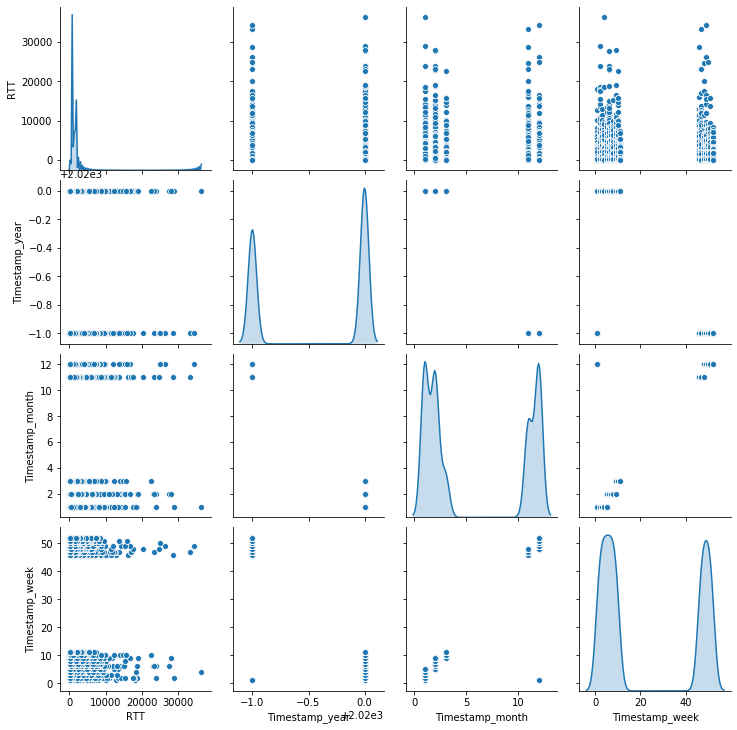

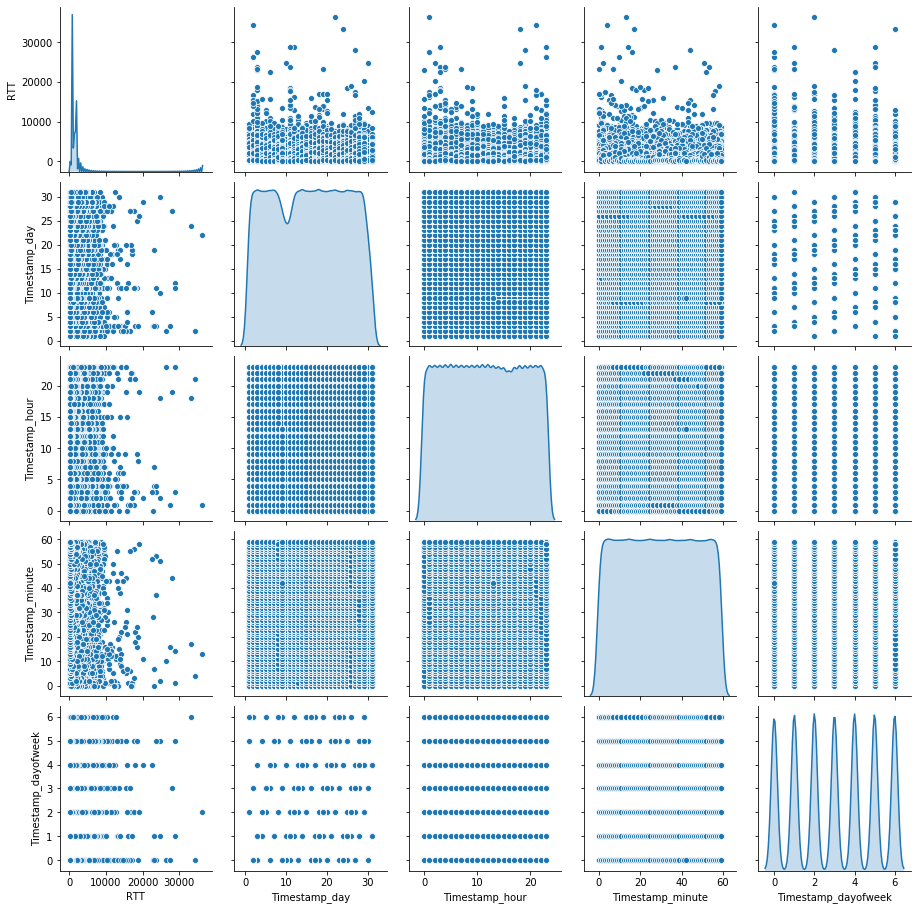

In [0]:
sns.pairplot(df[["RTT", "Timestamp_year", "Timestamp_month", "Timestamp_week"]], diag_kind="kde")
sns.pairplot(df[["RTT", "Timestamp_day", "Timestamp_hour", "Timestamp_minute", "Timestamp_dayofweek"]], diag_kind="kde")

8188 filtered examples
6550 train examples
1638 test examples


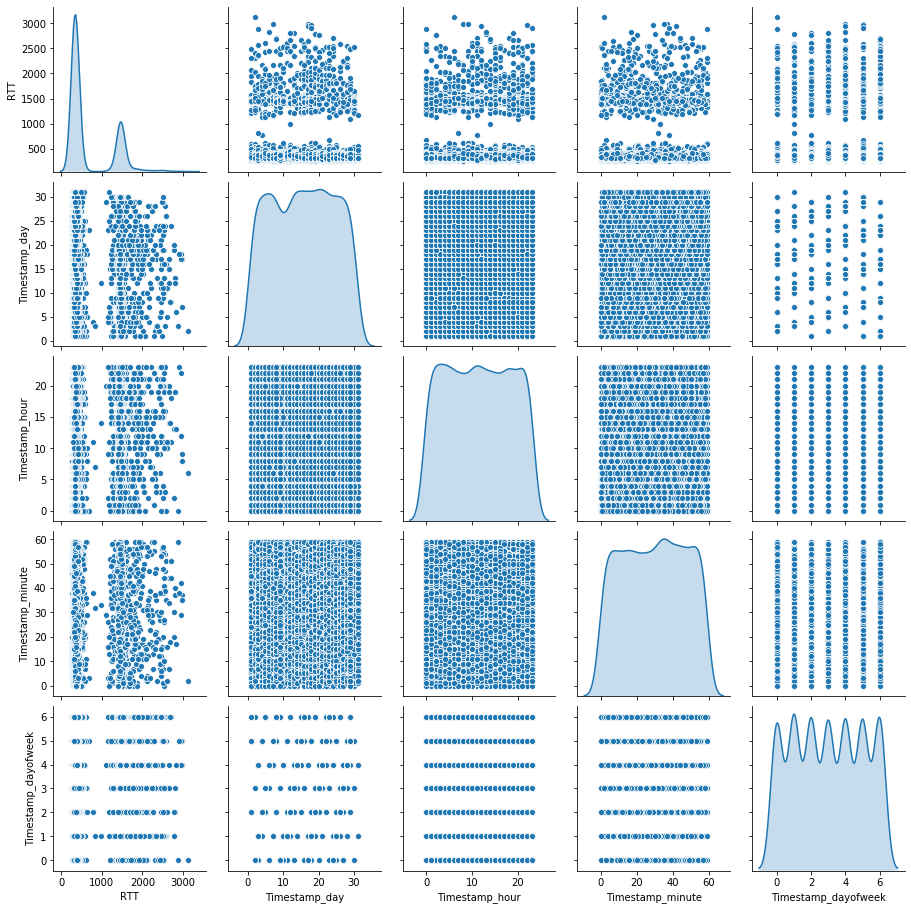

In [0]:
filtered_df = df.query("Checkpoint == 'Montreal' and Region == 'asia-east2'")
filtered_df = filtered_df[["RTT", "Timestamp_day", "Timestamp_hour", "Timestamp_minute", "Timestamp_dayofweek"]]
sns.pairplot(filtered_df[["RTT", "Timestamp_day", "Timestamp_hour", "Timestamp_minute", "Timestamp_dayofweek"]], diag_kind="kde")
print(len(filtered_df), 'filtered examples')

train, test = train_test_split(filtered_df, test_size=0.2)
#train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
#print(len(val), 'validation examples')
print(len(test), 'test examples')

In [0]:
train_stats = train.describe()
train_stats.pop("RTT")
train_stats = train_stats.transpose()
train_stats

count       mean        std  min   25%   50%   75%   max
Timestamp_day        6550.0  15.730382   8.754990  1.0   8.0  16.0  23.0  31.0
Timestamp_hour       6550.0  11.488244   6.971996  0.0   5.0  11.0  18.0  23.0
Timestamp_minute     6550.0  29.933740  17.346835  0.0  15.0  30.0  45.0  59.0
Timestamp_dayofweek  6550.0   2.996641   2.006705  0.0   1.0   3.0   5.0   6.0

In [0]:
train_labels = train.pop('RTT')
test_labels = test.pop('RTT')

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

print(train)

normed_train_data = norm(train)
normed_test_data = norm(test)

print(normed_train_data)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = '{:20,.2f}'.format
normed_train_data.describe()

        Timestamp_day  Timestamp_hour  Timestamp_minute  Timestamp_dayofweek
389492              8               8                30                    5
342561             28              16                38                    1
169738             20               8                44                    4
138257             13               5                10                    4
79828              29              22                54                    4
...               ...             ...               ...                  ...
347200             29              17                53                    2
351623             30              18                 1                    3
226566              2               7                36                    3
487435              1              14                57                    6
195015             26               2                46                    3

[6550 rows x 4 columns]
        Timestamp_day  Timestamp_hour  Timestamp_mi

Timestamp_day  ...  Timestamp_dayofweek
count             6,550.00  ...             6,550.00
mean                  0.00  ...                 0.00
std                   1.00  ...                 1.00
min                  -1.68  ...                -1.49
25%                  -0.88  ...                -0.99
50%                   0.03  ...                 0.00
75%                   0.83  ...                 1.00
max                   1.74  ...                 1.50

[8 rows x 4 columns]

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________


In [0]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.123],
       [-0.132],
       [-0.115],
       [ 0.111],
       [-0.272],
       [ 0.075],
       [ 0.066],
       [ 0.243],
       [ 0.04 ],
       [ 0.048]], dtype=float32)

In [0]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss                  mae  ...              val_mse  epoch
995           219,897.51               360.01  ...           239,579.36    995
996           219,475.01               358.95  ...           246,133.86    996
997           219,359.02               358.15  ...           246,542.80    997
998           220,213.86               359.55  ...           242,763.55    998
999           218,544.31               360.02  ...           248,597.41    999

[5 rows x 7 columns]

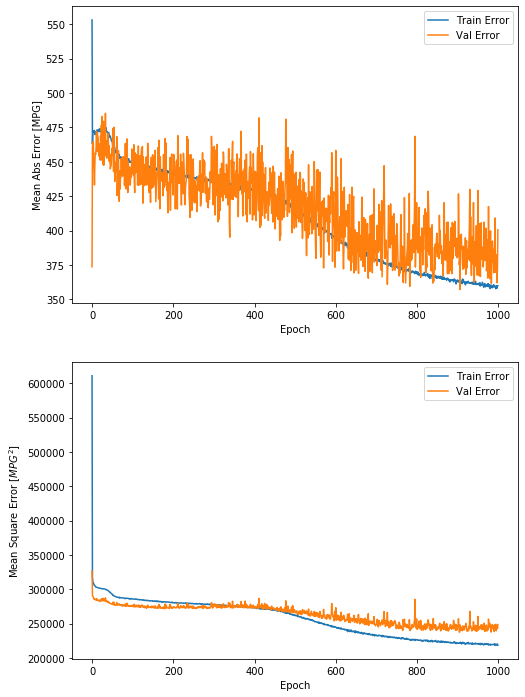

In [0]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)